In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import librosa 
import torch 
import torchaudio 
import torch.nn.functional as F 
import torchaudio.transforms as T 
from torch import Tensor 
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split, Dataset
from IPython.display import Audio, display



In [2]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)


In [3]:
audio_path = '/Users/stephen/Desktop/Speech_Commands/Data/SpeechCommands/speech_commands_v0.02/'

In [4]:
# list of label_list 
label_list = os.listdir(audio_path)
label_list.remove('.DS_Store')
label_list.remove('validation_list.txt')
label_list.remove('LICENSE')
label_list.remove('testing_list.txt')
label_list.remove('README.md')
label_list

['right',
 'eight',
 'cat',
 'tree',
 'backward',
 'learn',
 'bed',
 'happy',
 'go',
 'dog',
 'no',
 'wow',
 'follow',
 'nine',
 'left',
 'stop',
 'three',
 '_background_noise_',
 'sheila',
 'one',
 'bird',
 'zero',
 'seven',
 'up',
 'visual',
 'marvin',
 'two',
 'house',
 'down',
 'six',
 'yes',
 'on',
 'five',
 'forward',
 'off',
 'four']

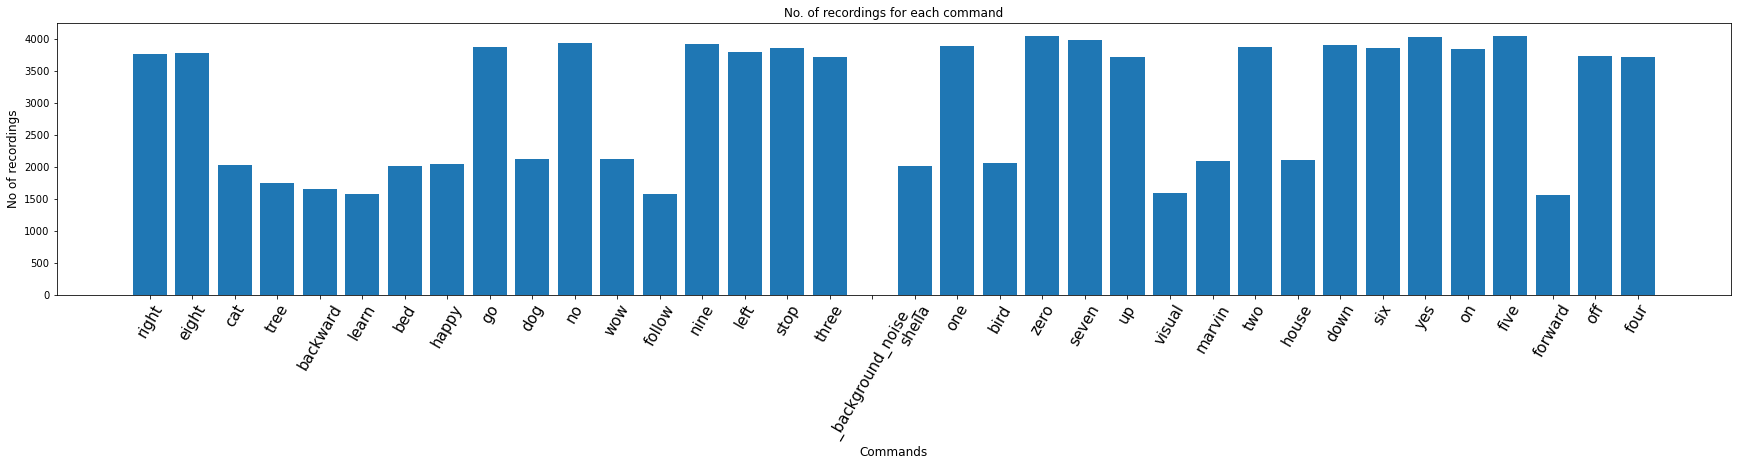

In [5]:
# count each label and plot results 
no_of_recordings = []
for label in label_list:
    waves = [f for f in os.listdir(audio_path + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

# plot 
plt.figure(figsize=(30,5))
index = np.arange(len(label_list))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, label_list, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [6]:
# selecting a random file. "forward"
test_file_path = '/Users/stephen/Desktop/Speech_Commands/Data/SpeechCommands/speech_commands_v0.02/forward/1a994c9f_nohash_3.wav'


In [7]:
waveform, sample_rate = torchaudio.load(test_file_path)

Sample Rate: 16000
Shape: (1, 16000)
Dtype: torch.float32
 - Max:      0.547
 - Min:     -0.318
 - Mean:     0.000
 - Std Dev:  0.072

tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0012, 0.0012, 0.0012]])



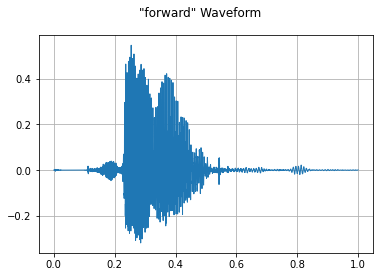

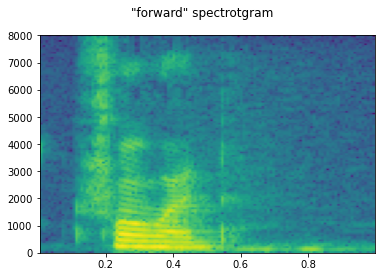

In [8]:
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate, title='"forward" Waveform')
plot_specgram(waveform, sample_rate, title='"forward" spectrotgram')
play_audio(waveform, sample_rate)

Shape: (1, 513, 32)
Dtype: torch.float32
 - Max:     1748.398
 - Min:      0.000
 - Mean:     1.937
 - Std Dev: 33.659

tensor([[[1.6290e-06, 2.8334e-07, 2.3487e-08,  ..., 1.6740e-03,
          2.8481e-04, 3.6512e-04],
         [3.1496e-06, 9.3471e-07, 5.4189e-07,  ..., 7.9350e-04,
          1.1353e-03, 2.1992e-04],
         [2.2417e-06, 1.0835e-06, 1.2982e-06,  ..., 9.1440e-05,
          7.9622e-04, 6.9843e-05],
         ...,
         [7.4558e-10, 1.6587e-08, 7.7284e-09,  ..., 2.9651e-08,
          1.3119e-07, 4.0401e-08],
         [2.3429e-11, 3.6097e-08, 1.8031e-08,  ..., 2.0644e-08,
          1.2795e-07, 1.0246e-07],
         [2.5222e-09, 1.3801e-08, 4.4074e-08,  ..., 5.8139e-08,
          2.3666e-07, 2.9103e-07]]])



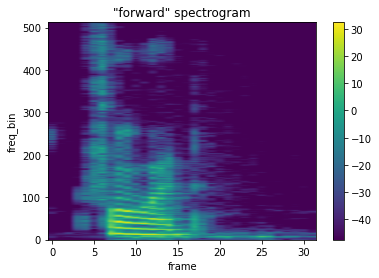

In [9]:
# Alternative way of looking at Spectrogram 

n_fft = 1024 
win_length = None 
hop_length = 512 

# define Transformation 
spectrogram = T.Spectrogram(
    n_fft=n_fft, 
    win_length=win_length, 
    center=True, 
    pad_mode='reflect',
    power=2.0
)

# perform transofrmation 
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='"forward" spectrogram')

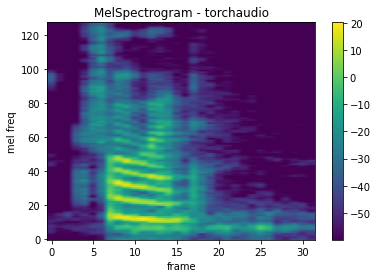

In [10]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

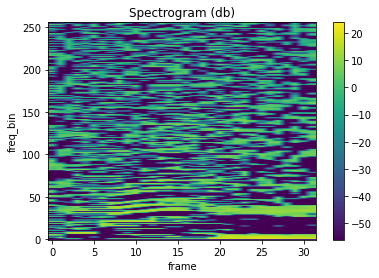

In [11]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

In [12]:
pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)

AttributeError: module 'torch.nn.functional' has no attribute 'detect_pitch_frequency'

In [ ]:
pitch_feature = F.compute_kaldi_pitch(waveform, sample_rate)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc)
play_audio(waveform, sample_rate)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

In [ ]:
model = bundle.get_model()
print(model.__class__)

In [ ]:


with torch.inference_mode():
    features, _ = model.extract_features(waveform)

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
  ax[i].imshow(feats[0].cpu())
  ax[i].set_title(f"Feature from transformer layer {i+1}")
  ax[i].set_xlabel("Feature dimension")
  ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [ ]:
torchaudio.sox_effects.effect_names()

In [ ]:
len(waveform[0])

In [ ]:

waveforms = []
labels = []

for label in label_list:
    print(label)
    waves = [f for f in os.listdir(audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        
        signal, sample_rate = torchaudio.load(audio_path + label + '/' + wav)
        if len(signal[0]) == 16000:

            waveforms.append(signal)
            labels.append(label)


In [ ]:
len(waveforms)

In [ ]:
len(waveforms[i][0])

In [ ]:
audio_path

In [ ]:
class SpeechDataLoader(Dataset):
    
    def __init__(self,data,labels,list_dir,transform=None):
        self.data = data
        self.labels = labels
        self.label_dict = list_dir
        self.transform = transform
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        waveform = self.data[idx]
        
        if self.transform != None:
            waveform = self.transform(waveform)

        if self.labels[idx] in self.label_dict:
            out_labels = self.label_dict.index(self.labels[idx])
            

        return waveform, out_labels
    

    

In [ ]:
# Dataset with MFCC's
n_fft = 2048
win_length = None 
nop_length = 512 
n_mels = 256 
n_mfcc = 13


dataset = SpeechDataLoader(waveforms, labels, label_list, transform=T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc,     melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }))

In [ ]:
print_stats(dataset[1][0])

In [ ]:
train_data, test_data = random_split(dataset, [round(len(dataset)*.8), round(len(dataset)*.2)])

trainloader = DataLoader(train_data, batch_size=100, shuffle=True)

testloader = DataLoader(test_data, batch_size=100, shuffle=True)

In [ ]:
len(trainloader)

In [ ]:
train_features, train_labels = next(iter(trainloader))
train_features

In [ ]:
# 1D CNN with 
class CNN2D(nn.Module):
    def __init__(self, outputs):
        super(CNN2D, self).__init__()
        # First Convolutional layers
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=0, stride=1)
        #self.maxpool1=nn.MaxPool1d(kernel_size=5, stride=1)
        self.dropout1 = nn.Dropout(0.3)

        # Second Convolutional Layers
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=0, stride=1)
        #self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=1)
        self.dropout2 = nn.Dropout(0.3)

        # Third Conv loyer
        #self.cnn3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, padding=0, stride=1)
        #self.dropout3 = nn.Dropout(0.3)

        # fourth Conv layer 
        #self.cnn4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, padding=0, stride=1)
        #self.dropout4 = nn.Dropout(0.3)

        self.fc1 = nn.Linear(384, 256) 
        self.dropout5 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256,128)
        self.dropout6 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, outputs)
        
    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.cnn1(x)),kernel_size=3)
        x = self.dropout1(x)
        
        x = F.max_pool2d(F.relu(self.cnn2(x)),kernel_size=3)
        x = self.dropout2(x)
        
        x = F.max_pool2d(F.relu(self.cnn3(x)),kernel_size=3)
        x = self.dropout3(x)
        
        x = F.max_pool2d(F.relu(self.cnn4(x)),kernel_size=3)
        x = self.dropout4(x)
        
        x = F.relu(self.fc1(x.reshape(-1,x.shape[1] * x.shape[2])))
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        
        #print(x.shape)
        return x 


In [ ]:
model = CNN2D(36)

In [ ]:
model

In [ ]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()


# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()


In [ ]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [ ]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

# number of epochs 
def train(train_loader, test_loaders, criterion, model, optimizer, epochs):

    n_epochs = 1
    cost_list = []
    accuracy_list = []
    N_test = len(test_data)
    cost = 0


    for epoch in range(n_epochs):
        cost = 0
    for x, y in trainloader:
        # clear gradient
        optimizer.zero_grad()
        # make prediction 
        z = model(x)
        # calculate loss
        loss = criterion(z, y)
        # calculate gradients of parameters 
        loss.backward()
        # update params
        optimizer.step()
        cost += loss.item()
    cost_list.append(cost)


    correct = 0
    # perform a prediction on test data
    for x_test, y_test in testloader:

        z = model(x_test)
        _, yhat = torch.max(z.data,1)

        correct += (yhat == y_test).sum().item()

    accuracy = correct / N_test
    accuracy_list.append(accuracy)




In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

View the results of the parameters for the Convolutional layers

In [ ]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

Determine the activations

In [ ]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Plot out the first set of activations 

In [ ]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

The image below is the result after applying the relu activation function

In [ ]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

The image below is the result of the activation map after the second output layer.

In [ ]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

The image below is the result of the activation map after applying the second relu

In [ ]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")